In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from ml_utils import graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from feature_selector import FeatureSelector
from file_loader import FileLoader

import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['plot', 'clf']
`%matplotlib` prevents importing * from pylab and numpy



In [271]:
# ['o1', 'o2', 'o3', 'o4', 'o5']
fl = FileLoader(['o1', 'o2', 'o3', 'o4', 'o5'], mode='u', dim=[1, 2])

Loaded dataframe: (964, 53)
Loaded dataframe: (965, 1)
Loaded dataframe: (965, 53)
971831.5300829875
1245556.580310881


In [243]:
fl.df.sort_values(['speedup'])['speedup']

alg                                             run                                           
lore_b38996ea-1dfb-4960-8f81-eb559af5d62f_42    -D PARAM_N=7071                                   0.667221
lore_f86801b9-79fa-4198-8efc-96099b09dc78_581   -D PARAM_W=57734 -D PARAM_H=57734                 0.734608
lore_45b5111a-30d1-414a-ac0a-5c58f1d51f37_502   -D PARAM_W=57734 -D PARAM_H=57734                 0.736453
                                                -D PARAM_W=40824 -D PARAM_H=40824                 0.736567
lore_f86801b9-79fa-4198-8efc-96099b09dc78_581   -D PARAM_W=40824 -D PARAM_H=40824                 0.739889
lore_e90955a5-6c8c-409d-af83-2c5778d5419e_1486  -D PARAM_NGROUPS=50000000                         0.801101
lore_071e0363-89a9-4aac-9f74-05b0f47c1098_573   -D PARAM_W=40824 -D PARAM_H=40824                 0.863918
                                                -D PARAM_W=57734 -D PARAM_H=57734                 0.864457
lore_aeac982e-58a5-4135-866e-0ad1de6e761d_291   -

In [272]:
fl.split()

In [273]:
fs = FeatureSelector('step')
fs.fit(fl.x_train, fl.y_train, fl.df_train, n_iter=5)
x = fs.transform(fl.x_train)
x_test = fs.transform(fl.x_test)
y, y_test = fl.y_train, fl.y_test
df, df_test = fl.df_train, fl.df_test
feats = [df.columns[q] for q in fs.feats]

Performing step feature selection (step=5, n_iter=5)
Iteration 1 / 5
Iteration 2 / 5
Iteration 3 / 5
Iteration 4 / 5
Iteration 5 / 5
Best score in training set: 0.14
Selected 11 features:
	PAPI_TOT_INS
	PAPI_BR_MSP
	PAPI_CA_CLN
	PAPI_L1_DCA
	PAPI_L1_ICA
	PAPI_L1_LDM
	PAPI_L2_DCR
	PAPI_L2_LDM
	PAPI_L2_TCA
	PAPI_L2_TCR
	PAPI_TLB_DM


In [120]:
x, x_test = fl.x_train, fl.x_test
y, y_test = fl.y_train, fl.y_test
df, df_test = fl.df, fl.df_test

In [274]:
clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
clf.fit(x, y) 
clf.score(x_test, y_test)

0.21059323701595575

0.88 	 0.96
0.88 	 0.92
0.89 	 0.96
0.9 	 0.92
0.9 	 1.04
0.92 	 0.93
0.93 	 1.04
0.93 	 0.79
0.94 	 0.95
0.94 	 0.93
0.94 	 0.94
0.94 	 0.93
0.95 	 0.88
0.96 	 0.99
0.96 	 0.95
0.97 	 0.99
0.98 	 1.01
0.98 	 1.01
0.98 	 0.99
0.98 	 0.99
0.98 	 0.99
0.99 	 0.99
0.99 	 0.96
0.99 	 0.99
0.99 	 1.02
0.99 	 0.99
0.99 	 1.0
0.99 	 1.0
0.99 	 0.99
0.99 	 0.93
0.99 	 0.99
0.99 	 0.99
0.99 	 1.07
0.99 	 1.01
0.99 	 0.99
1.0 	 1.0
1.0 	 1.0
1.0 	 1.01
1.0 	 0.99
1.0 	 1.01
1.0 	 1.0
1.0 	 1.01
1.0 	 0.99
1.0 	 0.99
1.0 	 1.0
1.0 	 1.01
1.0 	 0.94
1.01 	 1.0
1.01 	 1.0
1.01 	 1.01
1.01 	 0.99
1.01 	 1.01
1.01 	 1.0
1.01 	 0.94
1.02 	 0.95
1.02 	 1.55
1.02 	 1.02
1.02 	 1.01
1.03 	 1.01
1.03 	 1.02
1.03 	 1.01
1.07 	 1.04
1.07 	 0.99
1.08 	 1.08
1.09 	 1.01
1.1 	 1.08
1.37 	 1.38
1.39 	 1.39
1.4 	 1.01
1.4 	 1.01
1.41 	 1.39


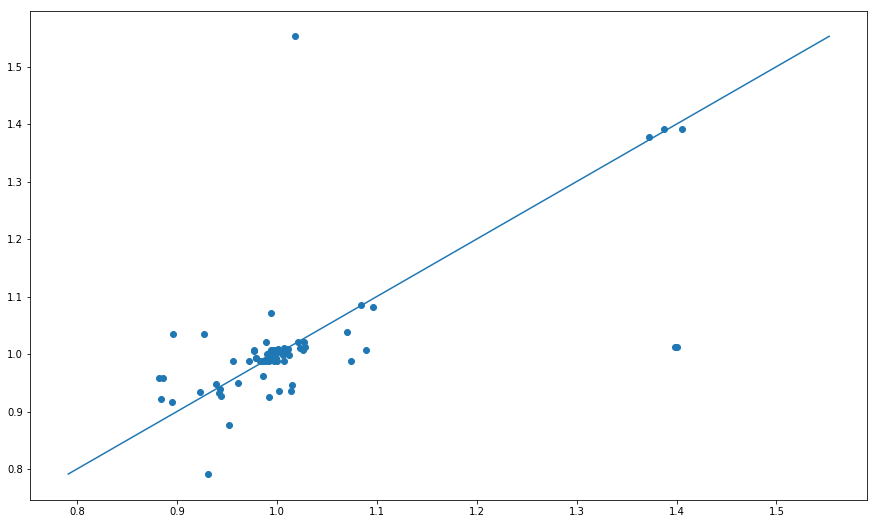

In [275]:
y_pred = clf.predict(x_test)
for yt, yp in sorted(list(zip(y_test, y_pred)), key=lambda q: q[0]):
    print(round(yt, 2), '\t', round(yp, 2))
    
plt.scatter(y_test, y_pred)
minv = min(min(y_test), min(y_pred))
maxv = max(max(y_test), max(y_pred))
plt.plot([minv, maxv], [minv, maxv])

In [265]:
if x.shape[1] != 2:
    pca = PCA(n_components=2)
    x2 = pca.fit_transform(x)
        
groups = list(df.index.get_level_values(0))
labels = [q[-6:] for q in groups]

trace1 = go.Scatter(x=x2[:,0], y=x2[:,1], mode='markers', text=labels, hoverinfo='text',
                        marker = dict(size=8, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False, hovermode='closest',
               yaxis=dict(zeroline=False, title='dim2'),
               xaxis=dict(zeroline=False, title='dim1'))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [126]:
fl = FileLoader(['o3'], mode='u', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(fl.x_train, fl.y_train) 
    scores.append(clf.score(fl.x_test, fl.y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (207, 53)
Loaded dataframe: (208, 1)
10
20
30
40
-1.09 +/- 2.03


In [4]:
fl = FileLoader(['o1c'], mode='speedup', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    
    fs = FeatureSelector('pca')
    fs.fit(fl.x_train, fl.y_train, fl.df_train, pca_comp=11)
    x = fs.transform(fl.x_train)
    x_test = fs.transform(fl.x_test)
    y, y_test = fl.y_train, fl.y_test
    df, df_test = fl.df_train, fl.df_test
    
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(x, y) 
    scores.append(clf.score(x_test, y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (10630, 53)
Loaded dataframe: (10629, 1)
10
20
30
40
0.29 +/- 0.16


In [ ]:
fl = FileLoader(['o1c'], mode='speedup', dim=[1, 2])
scores = []

for i in range(40):
    if (i+1)%10 == 0:
        print(i+1)
    fl.split()
    
    fs = FeatureSelector('nca')
    fs.fit(fl.x_train, fl.y_train, fl.df_train, nca_dim=16)
    x = fs.transform(fl.x_train)
    x_test = fs.transform(fl.x_test)
    y, y_test = fl.y_train, fl.y_test
    df, df_test = fl.df_train, fl.df_test
    
    clf = KNeighborsRegressor(n_neighbors=6, weights='distance')
    clf.fit(x, y) 
    scores.append(clf.score(x_test, y_test))
    
print(round(np.mean(scores), 2), '+/-', round(np.std(scores), 2))

Loaded dataframe: (10630, 53)
Loaded dataframe: (10629, 1)
   0 -3175.960816
   1 -3188.366689
   2 -3211.896278
   3 -3263.084757
   4 -3327.654113
   5 -3387.862917
   6 -3423.353179
   7 -3452.158065
   8 -3483.276954
   9 -3511.312155


In [16]:
res = {}
for c in df.columns:
    res[c] = 0

for i in range(40):
    fs = FeatureSelector('step')
    fs.fit(fl.x, fl.y, fl.df)
    x = fs.transform(fl.x)
    x_test = fs.transform(fl.x_test)
    feats = [fl.df.columns[q] for q in fs.feats]
    for f in feats:
        res[f] += 1
        
resl = [(k, v) for k, v in res.items()]
resl = sorted(resl, key=lambda q: q[1], reverse=True)
for k, v in resl:
    print(k, '\t', v)

Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.58
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCM
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.6
Selected 17 features:
	PAPI_BR_INS
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_HW_INT
	PAPI_L1_STM
	PAPI_L2_DCM
	PAPI_L2_DCW
	PAPI_L2_LDM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.54
Selected 10 features:
	PAPI_FDV_INS
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_SP_OPS
	PAPI_TLB_DM
	PAPI_TOT_CYC
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.5
Selected 15 features:
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_FP_INS
	P

Best score in training set: 0.6
Selected 7 features:
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L2_DCW
	PAPI_TLB_DM
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 10 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_TLB_IM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 11 features:
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L2_DCM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_RES_STL
	PAPI_TLB_DM
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.51
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L2_DCR
	PAPI_L2_DCW
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.

Best score in training set: 0.51
Selected 12 features:
	PAPI_CA_SHR
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_DCH
	PAPI_L2_DCM
	PAPI_L2_TCA
	PAPI_L2_TCM
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_SR_INS
	PAPI_TLB_DM
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.49
Selected 9 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCM
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_TOT_CYC
	PAPI_VEC_INS
	PAPI_VEC_SP
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.55
Selected 9 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_L1_TCA
	PAPI_L2_DCW
	PAPI_L2_TCM
	PAPI_L2_TCW
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_TOT_IIS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.5
Selected 9 features:
	PAPI_FDV_INS
	PAPI_FP_OPS
	PAPI_L1_ICM
	PAPI_L1_STM
	PAPI_L2_DCA
	PAPI_L2_STM
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_VEC_INS
Performing step feature selection (step=5, n_iter=1)
Iterati

Best score in training set: 0.51
Selected 8 features:
	PAPI_BR_NTK
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_L2_DCR
	PAPI_L2_DCW
	PAPI_L2_STM
	PAPI_L2_TCH
	PAPI_LD_INS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.51
Selected 12 features:
	PAPI_BR_INS
	PAPI_CA_SHR
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_DCM
	PAPI_L1_ICA
	PAPI_L1_STM
	PAPI_L1_TCM
	PAPI_L2_DCM
	PAPI_LD_INS
	PAPI_REF_CYC
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.57
Selected 10 features:
	PAPI_BR_INS
	PAPI_FDV_INS
	PAPI_FML_INS
	PAPI_L1_ICM
	PAPI_L1_TCM
	PAPI_L2_DCA
	PAPI_L2_DCM
	PAPI_L2_LDM
	PAPI_LD_INS
	PAPI_SP_OPS
Performing step feature selection (step=5, n_iter=1)
Iteration 1 / 1
Best score in training set: 0.49
Selected 12 features:
	PAPI_BR_NTK
	PAPI_DP_OPS
	PAPI_FDV_INS
	PAPI_FP_INS
	PAPI_FP_OPS
	PAPI_L1_DCH
	PAPI_L2_TCH
	PAPI_LD_INS
	PAPI_SP_OPS
	PAPI_TLB_DM
	PAPI_TOT_IIS
	PAPI_VEC_INS
Performing step fea

In [39]:
trace1 = go.Scatter3d(x=x2[:,0], y=x2[:,1], z=x2[:,2], mode='markers', hoverinfo='none',
                        marker = dict(size=2, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False,
               yaxis=dict(zeroline=False, title='dim2', ticks='', showticklabels=False),
               xaxis=dict(zeroline=False, title='dim1', ticks='', showticklabels=False))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

IndexError: index 2 is out of bounds for axis 1 with size 2

In [9]:
model_path = '../lore/models/'
joblib.dump(scaler, model_path + 'scaler.pkl') 
joblib.dump(pca, model_path + 'pca.pkl')
joblib.dump(neigh, model_path + 'neigh.pkl') 

['../lore/models/neigh.pkl']